In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import time

In [2]:
start = time.time()
df = pd.read_csv('co2_data.csv')
end = time.time()
print("Loading took " + str(round(end - start, 2)) + " seconds")

Loading took 0.0 seconds


In [3]:
df.head(5)

,CO2,Year&Month,Year
0,333.13,1974.38,1974
1,332.09,1974.46,1974
2,331.10,1974.54,1974
3,329.14,1974.63,1974
4,327.36,1974.71,1974


In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import random

def plot_seasonal_decompose(df, column_name, model='additive', period=None):
    """
    Perform seasonal decomposition on a time series and plot the results.
    Parameters:
    df (DataFrame): The input DataFrame containing the time series data.
    column_name (str): The name of the column in the DataFrame to decompose.
    model (str): The type of decomposition ('additive' or 'multiplicative'). Default is 'additive'.
    period (int): The number of observations per cycle. If None, it will be inferred.
    Returns:
    None
    """
    # Perform seasonal decomposition
    result = seasonal_decompose(df[column_name], model=model, period=period)
    trend = result.trend.dropna()
    seasonal = result.seasonal.dropna()
    residual = result.resid.dropna()

    # Generate random colors for each plot
    base_color = [random.random() for _ in range(3)]  # Generate a random RGB color

    # Plotting the decomposition with random colors
    plt.figure(figsize=(10, 10))
    plt.suptitle('Seasonal Decomposition of ' + column_name, fontsize=16)
    plt.subplot(4, 1, 1)
    plt.plot(df[column_name], color=base_color, label='Original Series')
    plt.legend(loc='upper left')
    
    plt.subplot(4, 1, 2)
    plt.plot(trend, color=base_color, label='Trend')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 3)
    plt.plot(seasonal, color=base_color, label='Seasonal')
    plt.legend(loc='upper left')

    plt.subplot(4, 1, 4)
    plt.plot(residual, color=base_color, label='Residuals')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()


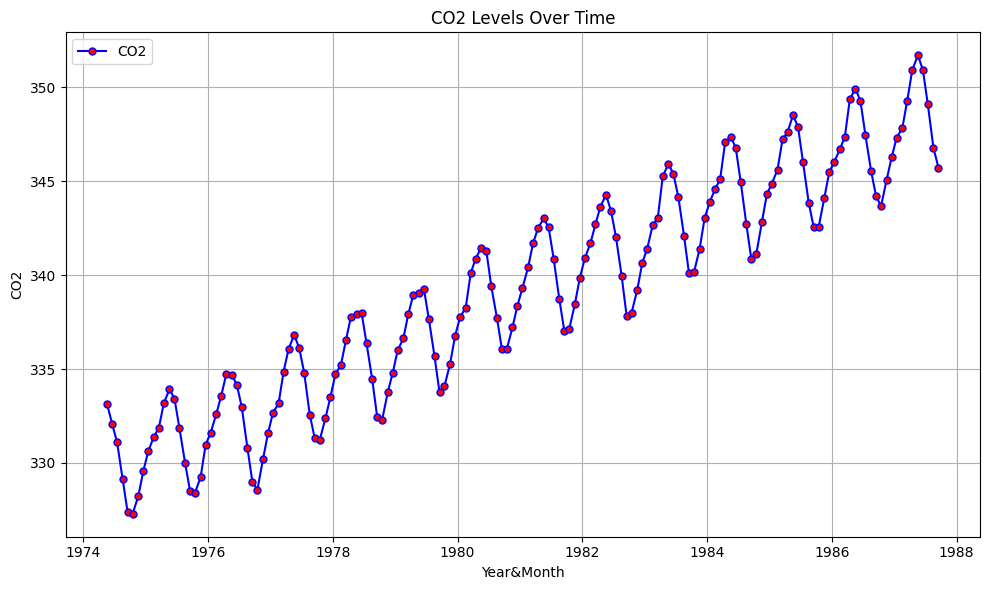

In [5]:
def plot_levels_overtime(df, x_column="Year&Month", y_column="CO2"):
    plt.figure(figsize=(10, 6))
    plt.plot(df[x_column], df[y_column], marker='o', markersize=5, markerfacecolor='red', color='blue', label=y_column)
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    plt.title(f"{y_column} Levels Over Time")
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.tight_layout()
    plt.show()


plot_levels_overtime(df, 'Year&Month', 'CO2')

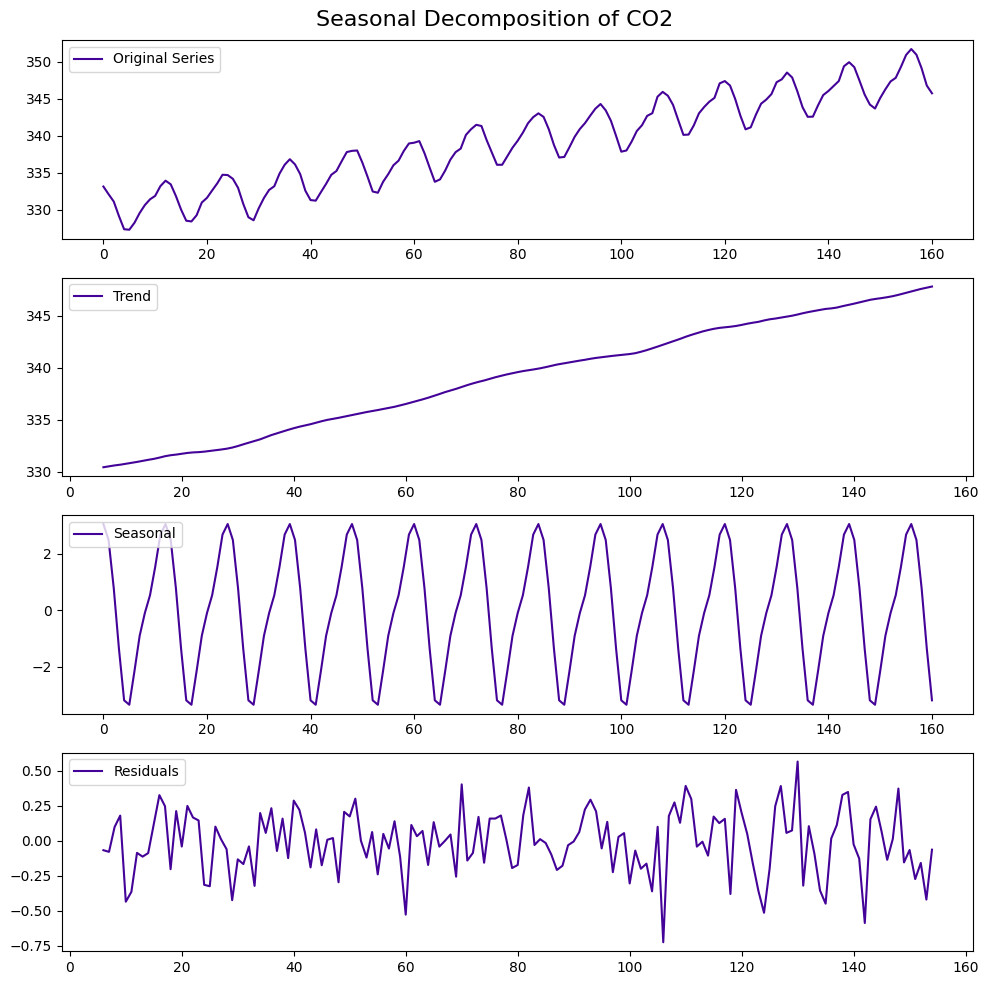

In [6]:
plot_seasonal_decompose(df, column_name='CO2', model='additive', period=12)

In [7]:
def plot_train_test_split(df, index_column, target_column, train_start, test_start, figsize=(15, 8)):
    """
    Parameters:
    - df: DataFrame ที่มีข้อมูล
    - index_column: ชื่อคอลัมน์ที่จะตั้งเป็น index
    - target_column: ชื่อคอลัมน์เป้าหมาย (target) ที่ต้องการวิเคราะห์
    - train_start: จุดเริ่มต้นของข้อมูลการฝึก (รูปแบบ timestamp หรือ float)
    - test_start: จุดเริ่มต้นของข้อมูลการทดสอบ (รูปแบบ timestamp หรือ float)
    - figsize: ขนาดของกราฟ (ค่าเริ่มต้น: (15, 8))
    """
    # ตั้งค่าคอลัมน์ที่ใช้เป็น index
    df = df.set_index(index_column, drop=False)
    
    # แยกข้อมูลการฝึก (train) และการทดสอบ (test)
    train_data = df[(df.index < float(test_start)) & (df.index >= float(train_start))][[target_column]].rename(columns={target_column: 'train'})
    test_data = df[float(test_start):][[target_column]].rename(columns={target_column: 'test'})

    # รวมข้อมูล train และ test
    combined_data = train_data.join(test_data, how='outer')
    

    combined_data.plot(y=['train', 'test'], figsize=figsize, fontsize=12)
    plt.xlabel('timestamp', fontsize=12)
    plt.ylabel(target_column, fontsize=12)
    plt.title(f"Train-Test Split of {target_column}", fontsize=14)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    
    train = df.copy()[(df.index >= float(train_start)) & (df.index < float(test_start))][[target_column]]
    test = df.copy()[df.index >= float(test_start)][[target_column]]
    print('Training data shape: ', train.shape)
    print('Test data shape: ', test.shape)
    return train, test

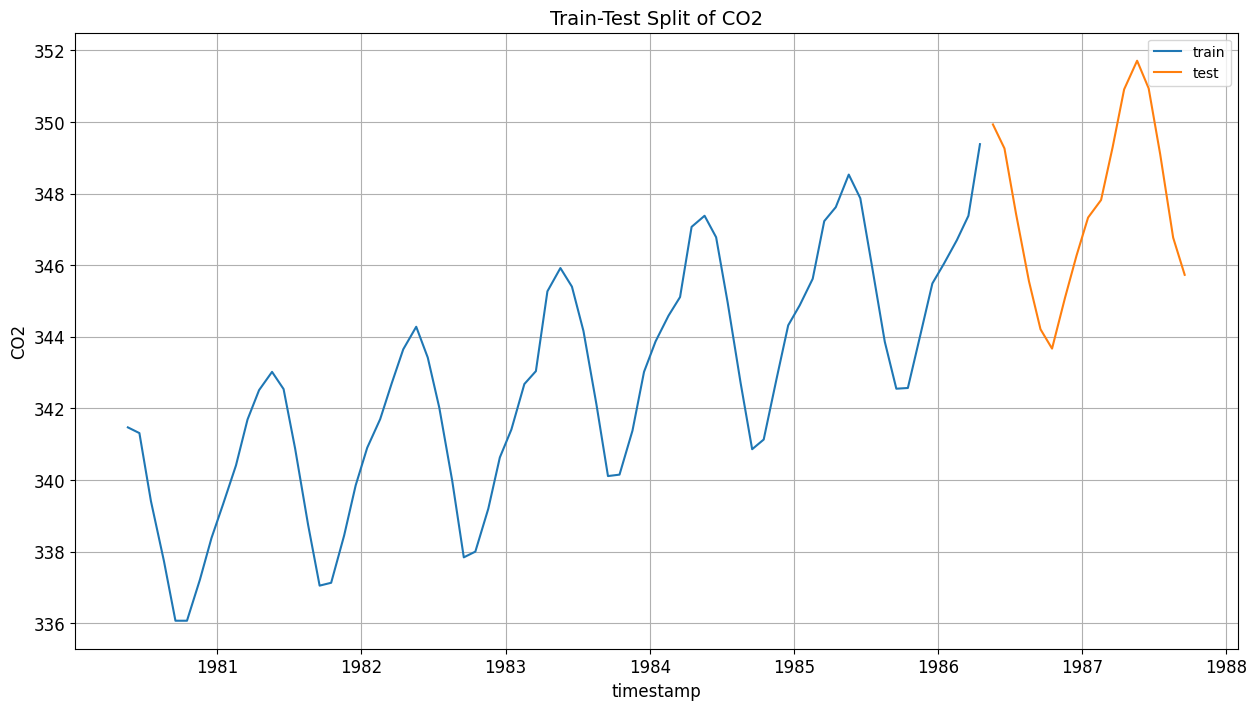

Training data shape:  (72, 1)
Test data shape:  (17, 1)


In [8]:
train, test = plot_train_test_split(df, index_column='Year&Month',target_column= 'CO2', 
                                    train_start='1980.38', 
                                    test_start='1986.38')

In [9]:
df.set_index('Year&Month', inplace=True)

In [10]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from tqdm import tqdm  
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm

In [11]:
SARIMAX_model = pm.auto_arima(train,
                           start_p=0, 
                           start_q=0,
                           test='adf',  # ใช้ ADF test เพื่อหา d
                           max_p=3, # ปรับเปลี่ยนตามความซับซ้อนของข้อมูล
                           max_q=3, # คล้ายกับ max_p ปรับเปลี่ยนให้เข้ากับข้อมูลเพื่อเพิ่มความสามารถของโมเดลในการคำนวณความผิดพลาด
                           m=52, # m คือ seasonality (12 สำหรับข้อมูลรายเดือน)
# ข้อมูลรายเดือน: m=12
# ข้อมูลรายไตรมาส: m=4
# ข้อมูลรายสัปดาห์: m=52
# ข้อมูลรายวัน:  m=7
                           start_P=0, # เริ่มต้นที่ 0 แต่สามารถเปลี่ยนได้ถ้าคุณเชื่อว่ามีอิทธิพลจากฤดูกาลในช่วงก่อนหน้า
                           seasonal=True,
                           d=None, # None
                           D=1,  # ให้ auto_arima ค้นหา d ที่เหมาะสม
                           trace=True, # ติดตามความก้าวหน้าในการสร้างโมเดล
                           error_action='ignore', # แสดงเตือนเมื่อเกิดข้อผิดพลาด 
                           suppress_warnings=True, # แสดงข้อความเตือนในระหว่างการทำงาน
                           stepwise=True) # True

# ดูค่าที่ auto_arima คำนวณได้
SARIMAX_model.summary()

d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\Tim

Performing stepwise search to minimize aic
 ARIMA(0,2,0)(0,1,1)[52]             : AIC=70.314, Time=0.97 sec
 ARIMA(0,2,0)(0,1,0)[52]             : AIC=68.314, Time=0.12 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,1,0)[52]             : AIC=69.832, Time=1.81 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(0,1,1)[52]             : AIC=69.770, Time=1.65 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1901: RuntimeWarning: divide by zero encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,0)(1,1,0)[52]             : AIC=70.314, Time=0.84 sec
 ARIMA(0,2,0)(1,1,1)[52]             : AIC=72.314, Time=1.09 sec
 ARIMA(1,2,0)(0,1,0)[52]             : AIC=67.832, Time=0.16 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(0,1,1)[52]             : AIC=69.832, Time=1.53 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,0)(1,1,1)[52]             : AIC=71.832, Time=1.73 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,2,0)(0,1,0)[52]             : AIC=68.285, Time=0.27 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,1)(0,1,0)[52]             : AIC=69.421, Time=0.26 sec
 ARIMA(0,2,1)(0,1,0)[52]             : AIC=67.770, Time=0.20 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,1,0)[52]             : AIC=69.770, Time=1.55 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,1)(1,1,1)[52]             : AIC=71.770, Time=1.80 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,2,2)(0,1,0)[52]             : AIC=68.465, Time=0.22 sec


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,2,2)(0,1,0)[52]             : AIC=70.460, Time=0.46 sec
 ARIMA(0,2,1)(0,1,0)[52] intercept   : AIC=69.711, Time=0.21 sec

Best model:  ARIMA(0,2,1)(0,1,0)[52]          
Total fit time: 14.902 seconds


d:\Anaconda\envs\TimeS\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                   72
Model:             SARIMAX(0, 2, 1)x(0, 1, [], 52)   Log Likelihood                 -31.885
Date:                             Sat, 18 Jan 2025   AIC                             67.770
Time:                                     20:00:28   BIC                             69.551
Sample:                                          0   HQIC                            68.015
                                              - 72                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.3850      0.268      1.437      0.151      -0.140       0.910
sigma2         2.0058      0.893      2.245      0.025       0.255       3.757
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.15
Prob(Q):                              0.94   Prob(JB):                         0.56
Heteroskedasticity (H):               0.65   Skew:                             0.43
Prob(H) (two-sided):                  0.61   Kurtosis:                         2.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [12]:
model = SARIMAX(train, order=(2,1, 1), seasonal_order=(0, 1, 0, 52))
model = model.fit(disp=1)

d:\Anaconda\envs\TimeS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
d:\Anaconda\envs\TimeS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [13]:
n = 17

In [14]:
prediction = model.get_forecast(steps=n)
prediction_index = test.index

d:\Anaconda\envs\TimeS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
d:\Anaconda\envs\TimeS\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [15]:
# ค่าที่คาดการณ์
predicted = prediction.predicted_mean
# กรอบความเชื่อมั่น
confidence_intervals = prediction.conf_int(alpha=0.40)

In [16]:
import numpy as np
test_values = np.array(test)  # Replace with your actual test values
predicted_values = np.array(predicted)
mape = np.mean(np.abs((test_values - predicted_values) / test_values)) * 100

In [17]:
predicted.index = test.index

MAPE: 1.50%


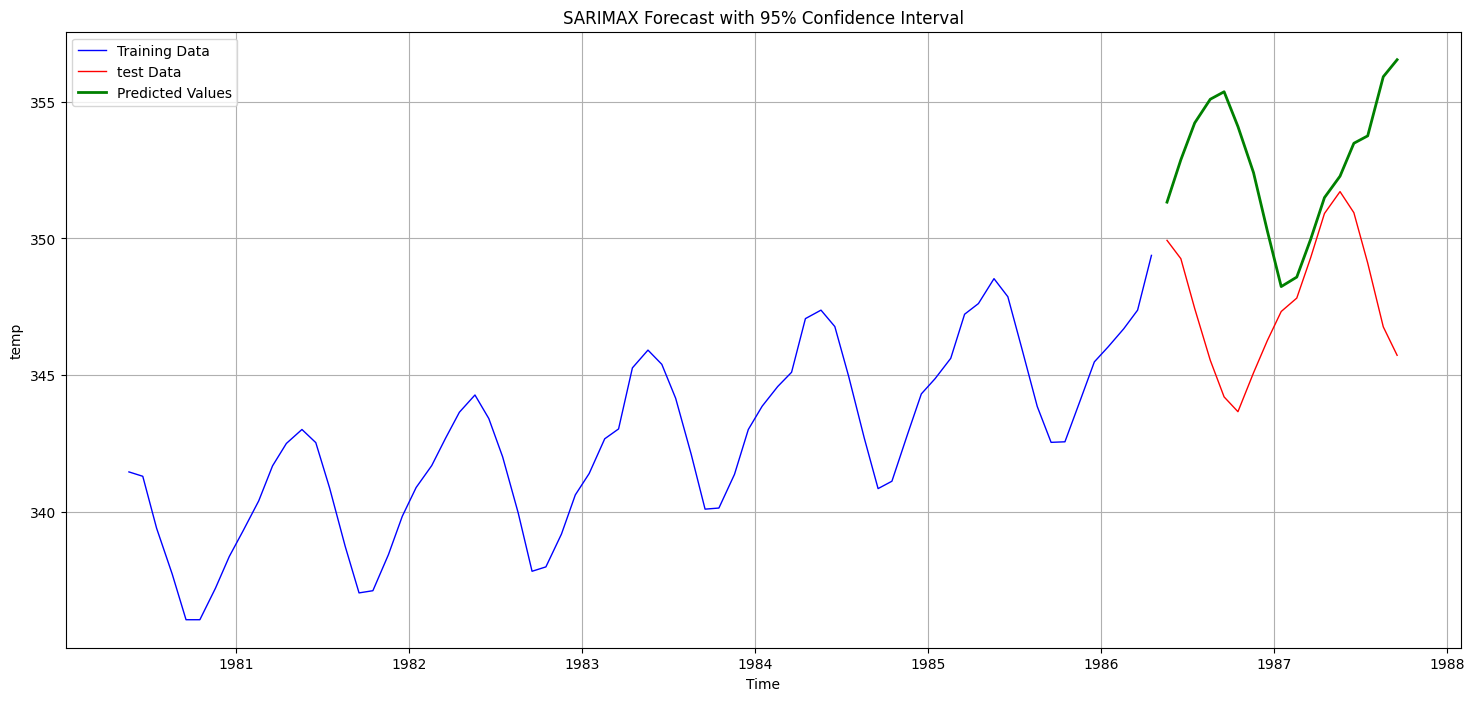

In [18]:
# สร้างกราฟ
print(f'MAPE: {mape:.2f}%')
plt.figure(figsize=(18, 8))
plt.plot( train, label='Training Data', color='blue',linewidth=1)  # ข้อมูลที่ใช้ฝึก
plt.plot( test, label='test Data', color='red',linewidth=1)
plt.plot( predicted, label='Predicted Values',color ='green',linewidth=2)  # ค่าที่คาดการณ์

# เพิ่มรายละเอียดกราฟ
plt.title('SARIMAX Forecast with 95% Confidence Interval')
plt.xlabel('Time')
plt.ylabel('temp')
plt.legend()
plt.grid()
plt.show()